In [95]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec

from green_mood_tracker.training_data import get_raw_data_notebook
from green_mood_tracker.data_cleaning import clean

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## download and clean data

In [96]:
%%time
raw_data = get_raw_data_notebook(True)
raw_data.head()

Wall time: 14.7 s


,id,text,polarity,source
0,1467933112,the angel is going to miss the athlete this we...,0,sts_gold
1,2323395086,It looks as though Shaq is getting traded to C...,0,sts_gold
2,1467968979,@clarianne APRIL 9TH ISN'T COMING SOON ENOUGH,0,sts_gold
3,1990283756,drinking a McDonalds coffee and not understand...,0,sts_gold
4,1988884918,So dissapointed Taylor Swift doesnt have a Twi...,0,sts_gold


In [97]:
raw_data.shape

(1620501, 4)

## Explore data

In [98]:
raw_data.source.value_counts()

sentiment140              1600000
kaggle_sentiment_train      16363
kaggle_sentiment_test        2104
sts_gold                     2034
Name: source, dtype: int64

In [99]:
raw_data.polarity.value_counts()

1    810317
0    810184
Name: polarity, dtype: int64

## sample data

In [100]:
# data_sample = raw_data[raw_data.source == 'sts_gold']
data_sample = raw_data[raw_data.source != 'sentiment140']

In [101]:
%%time
data_sample_clean = clean(data_sample,'text')
data_sample_clean.head()

Wall time: 4.99 s


,id,text,polarity,source
0,1467933112,"[angel, going, miss, athlete, weekend]",0,sts_gold
1,2323395086,"[look, though, shaq, getting, traded, clevelan...",0,sts_gold
2,1467968979,"[april, th, isnt, coming, soon, enough]",0,sts_gold
3,1990283756,"[drinking, mcdonalds, coffee, understanding, s...",0,sts_gold
4,1988884918,"[dissapointed, taylor, swift, doesnt, twitter]",0,sts_gold


## split data Train/Test

In [125]:
from sklearn.model_selection import train_test_split

X = data_sample_clean.text.map(lambda x: x.split())
y = data_sample_clean.polarity

In [126]:
sentence_train, sentence_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

In [127]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

## word2vec

In [128]:
# word2vec = Word2Vec(sentences=sentence_train)
# vocab_size=len(word2vec.wv.vocab.keys())

In [129]:
# vocab_size

2871

In [130]:
def embed_sentence(word2vec, sentence):
    embedded=[]
    embedded_sentence = []
    for word in sentence:
         if word in word2vec.wv.vocab.keys():
             vector = word2vec.wv[word]
             embedded_sentence.append(vector)                 
    return np.array(embedded_sentence)
        

In [131]:
def embedding(word2vec, sentences):
    embedding=[]
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)  
        embedding.append(embedded_sentence)
    return embedding

In [132]:
def embedding_pipeline(word2vec, X):
    # Step #3: Sentences to list of words
    X = embedding(word2vec, X) 
    # Step #4: Pad the inputs
    X = pad_sequences(X, dtype='float32', padding='post') 
    return X

In [148]:
# X_train_pad_w2v = embedding_pipeline(word2vec, sentence_train.values)
# X_test_pad_w2v = embedding_pipeline(word2vec, sentence_test.values)

In [220]:
def init_model_w2v():

    model = Sequential()

    model.add(layers.Masking(mask_value=0.))
    model.add(layers.GRU(units=32, activation='tanh', return_sequences=True)) 
    model.add(layers.GRU(units=16, activation='tanh')) 
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss= 'binary_crossentropy',  
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

### Train word2vec on internal data

In [150]:
# %%time
# model_w2v = init_model_w2v()

# es = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_accuracy')
# history_w2v = model_w2v.fit(X_train_pad_w2v, y_train,
#           validation_split= 2/7,
#           epochs=50, 
#           batch_size=32, 
#           verbose=1,
#           use_multiprocessing=True,
#           callbacks = [es])

In [151]:
# print('accuracy', model_w2v.evaluate(X_test_pad_w2v,y_test)[1])
# plot_loss(history_w2v)

### Train word2vec on Google news

In [152]:
%%time
import gensim.downloader as api

Wall time: 0 ns


In [153]:
%%time
word2vec_gnews = api.load("word2vec-google-news-300")

Wall time: 1min 26s


In [154]:
X_train_pad_w2v_gnews = embedding_pipeline(word2vec_gnews, sentence_train.values)
X_test_pad_w2v_gnews = embedding_pipeline(word2vec_gnews, sentence_test.values)

c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [155]:
X_test_pad_w2v_gnews.shape

(4101, 19, 300)

In [156]:
len(word2vec_gnews.wv.vocab)

c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


3000000

In [221]:
%%time
model_w2v_gnews = init_model_w2v()

es = EarlyStopping(patience=10,restore_best_weights=True,monitor='val_accuracy')
history_w2v_gnews = model_w2v_gnews.fit(X_train_pad_w2v_gnews, y_train,
          validation_split= 2/7,
          epochs=50, 
          batch_size=32, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/50
367/367 [==============================] - 6s 16ms/step - loss: 0.4500 - accuracy: 0.8026 - val_loss: 0.3442 - val_accuracy: 0.8566
Epoch 2/50
367/367 [==============================] - 5s 14ms/step - loss: 0.3468 - accuracy: 0.8597 - val_loss: 0.3144 - val_accuracy: 0.8730
Epoch 3/50
367/367 [==============================] - 5s 14ms/step - loss: 0.3182 - accuracy: 0.8711 - val_loss: 0.3031 - val_accuracy: 0.8747
Epoch 4/50
367/367 [==============================] - 5s 14ms/step - loss: 0.2972 - accuracy: 0.8794 - val_loss: 0.2993 - val_accuracy: 0.8760
Epoch 5/50
367/367 [==============================] - 5s 14ms/step - loss: 0.2829 - accuracy: 0.8859 - val_loss: 0.3329 - val_accuracy: 0.8600
Epoch 6/50
367/367 [==============================] - 5s 14ms/step - loss: 0.2655 - accuracy: 0.8869 - val_loss: 0.3391 - val_accuracy: 0.8634
Epoch 7/50
367/367 [==============================] - 5s 14ms/step - loss: 0.2537 - accuracy: 0.8971 - val_loss: 0.3075 - val_accuracy: 0.8784

129/129 [==============================] - 1s 10ms/step - loss: 0.3143 - accuracy: 0.8747
accuracy 0.8746647238731384


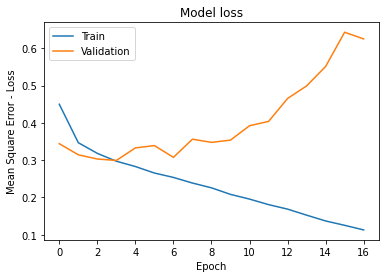

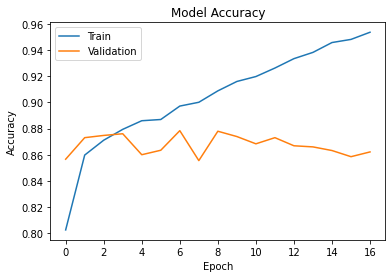

In [237]:
print('accuracy', model_w2v_gnews.evaluate(X_test_pad_w2v_gnews,y_test)[1])
plot_loss(history_w2v_gnews)

In [238]:
%%time
word2vec_glove = api.load("glove-twitter-100")

Wall time: 2min 5s


In [239]:
len(word2vec_glove.wv.vocab)

c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


1193514

In [240]:
X_train_pad_w2v_glove = embedding_pipeline(word2vec_glove, sentence_train.values)
X_test_pad_w2v_glove = embedding_pipeline(word2vec_glove, sentence_test.values)

c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [241]:
%%time
model_w2v_glove = init_model_w2v()

es = EarlyStopping(patience=10,restore_best_weights=True,monitor='val_accuracy')
history_w2v_glove = model_w2v_glove.fit(X_train_pad_w2v_glove, y_train,
          validation_split= 2/7,
          epochs=50, 
          batch_size=32, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/50
367/367 [==============================] - 7s 18ms/step - loss: 0.4420 - accuracy: 0.8004 - val_loss: 0.3377 - val_accuracy: 0.8566
Epoch 2/50
367/367 [==============================] - 8s 21ms/step - loss: 0.3377 - accuracy: 0.8609 - val_loss: 0.3144 - val_accuracy: 0.8673
Epoch 3/50
367/367 [==============================] - 7s 20ms/step - loss: 0.3090 - accuracy: 0.8748 - val_loss: 0.3274 - val_accuracy: 0.8579
Epoch 4/50
367/367 [==============================] - 10s 26ms/step - loss: 0.2917 - accuracy: 0.8814 - val_loss: 0.3400 - val_accuracy: 0.8570
Epoch 5/50
367/367 [==============================] - 7s 20ms/step - loss: 0.2754 - accuracy: 0.8853 - val_loss: 0.3316 - val_accuracy: 0.8585
Epoch 6/50
367/367 [==============================] - 7s 20ms/step - loss: 0.2603 - accuracy: 0.8924 - val_loss: 0.3157 - val_accuracy: 0.8754
Epoch 7/50
367/367 [==============================] - 7s 19ms/step - loss: 0.2511 - accuracy: 0.8999 - val_loss: 0.3461 - val_accuracy: 0.866

129/129 [==============================] - 1s 5ms/step - loss: 0.3202 - accuracy: 0.8761
accuracy 0.8761277794837952


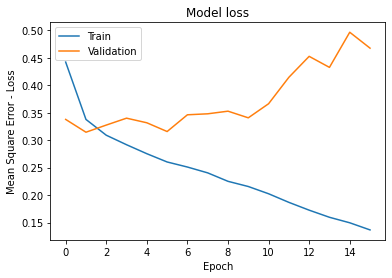

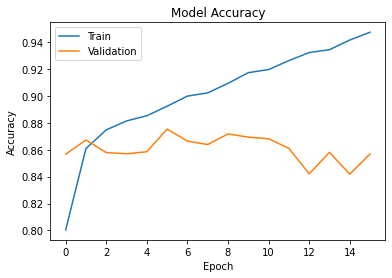

In [242]:
print('accuracy', model_w2v_glove.evaluate(X_test_pad_w2v_glove,y_test)[1])
plot_loss(history_w2v_glove)

In [243]:
# job save --- not working
# import joblib

# filename = 'model_emb_binary.joblib'
# joblib.dump(model_emb, filename)

# import pickle

# filename = 'model_emb_binary.sav'
# pickle.dump(model_emb, open(filename, 'wb'))

## Evaluate

In [244]:
# print('w2v_internal accuracy:',model_w2v.evaluate(X_test_pad_w2v,y_test))

In [245]:
# print('w2v_gnews accuracy:',model_w2v_gnews.evaluate(X_test_pad_w2v_gnews,y_test))

### Predict on London

In [246]:
# csv = pd.read_csv('../green_mood_tracker/data/london_nuclear.csv')